In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.cluster.vq import kmeans2
from skimage import io, color

%matplotlib inline

In [2]:
def diff(x,y):
    return np.abs( np.mod( x - y + 90, 180) - 90 )

def G(x,y,sigma=1):
    return np.exp(-1*diff(x,y)**2/(2*sigma**2))

def G2D(x_range, y_range, mean, sigma=1):
    x0 = mean[0]
    y0 = mean[1]
    return np.exp( -1*( ( x_range-x0)**2 + (y_range-y0)**2) / (2*sigma**2) )

# def G2DO(mean, sigma, o_map):
#     G = np.zeros(np.shape(o_map))
#     for i in range(np.shape(o_map)[0]):
#         for j in range(np.shape(o_map)[1]):
#             G[i,j] = np.exp(-0.5*d(o_map[mean], o_map[i,j])**2 / sigma**2)
#     return G

def G2DO(mean, sigma, o_map):
    return np.exp(-0.5*diff(o_map[mean], o_map)**2 / sigma**2)

def mean_connections(W_ab):
    total = 0.
    for i in range(W_ab.shape[0]):
        sub_mat = W_ab[i,:,:]
        total = total + sub_mat[sub_mat != 0].size
    return total / W_ab.shape[0]

def stimulus_size(x,length,sig_RF):
    return (1+np.exp((-x + length/2)/sig_RF) )**-1 * (1 - (1+np.exp((-x - length/2)/sig_RF))**-1 )

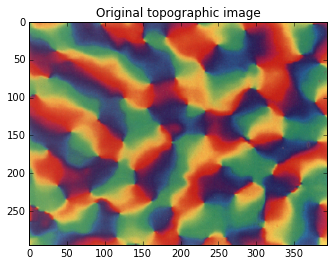

In [3]:
# Orientation preference map: for now, use k-means on Blasdel image
rgb_img = mpimg.imread('v1-topology-blasdel-figure6.png')

plt.figure()
plt.imshow(rgb_img)
plt.title('Original topographic image')

lab_img = color.rgb2lab(rgb_img) # convert to L*a*b* colourspace

ab = lab_img[:,:,1:]
n_rows = np.shape(ab)[0]
n_cols = np.shape(ab)[1]

ab = np.reshape(ab, (n_rows*n_cols, 2))
n_colours = 6

centroids, labels = kmeans2(ab, n_colours, iter=3)

labels = np.reshape(labels, (n_rows, n_cols))

rgb_labels = np.tile(labels[:,:,None], [1,1,3])

OP_range = np.linspace(0, 180, n_colours)
full_OP_map = np.copy(labels)

for i in range(n_colours):
    seg_img = np.copy(rgb_img)
    seg_img[rgb_labels != i] = 0  
    
    # assign an orientation preference (degrees) based on segmentation
    full_OP_map[full_OP_map == i] = OP_range[i]
    
    # Show the individual segmented images:
#     plt.figure()
#     plt.imshow(seg_img)


In [6]:
N_pairs = 75 # no. of E/I pairs to a side of a grid
field_size = 16. # size of field to a side (degrees)
dx = field_size / N_pairs

xy_range = np.linspace(0, field_size, N_pairs)
# xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# sample the OP map uniformly 
min_dim = np.min(np.shape(full_OP_map))
o_samples = np.round(np.linspace(0, min_dim-1, N_pairs))

xo, yo = np.meshgrid(o_samples, o_samples)

xo = xo.astype(int)
yo = yo.astype(int)

OP_map = full_OP_map[xo,yo]

# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5
J_EE = 0.1
J_IE = 0.38
J_EI = 0.089
J_II = 0.096

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45

# calculate probability of no connections for each neuron (sparse connectivity)

G_EE = np.zeros((N_pairs**2, N_pairs, N_pairs))
G_IE = np.copy(G_EE)
G_ori = np.copy(G_EE)

pW_EE = np.copy(G_EE)
pW_IE = np.copy(G_EE)
pW_EI = np.copy(G_EE)
pW_II = np.copy(G_EE)

rnd_EE = np.copy(G_EE)
rnd_IE = np.copy(G_EE)
rnd_EI = np.copy(G_EE)
rnd_II = np.copy(G_EE)
np.random.seed(1)

for i in range(N_pairs):
    for j in range(N_pairs):
        G_EE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EE)
        G_IE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_IE)
        G_ori[N_pairs*i+j, :, :] = G2DO((i,j), sig_ori, OP_map)
        rnd_EE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_IE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_EI[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_II[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)

for i in range(N_pairs**2):
    pW_EE[i,:,:] = kappa_E * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_IE[i,:,:] = kappa_E * np.multiply(G_IE[i,:,:], G_ori[i,:,:])
    pW_EI[i,:,:] = kappa_I * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_II[i,:,:] = kappa_I * np.multiply(G_IE[i,:,:], G_ori[i,:,:])
    
# find zero-weighted connections:
W_EE = np.ones((N_pairs**2, N_pairs, N_pairs))
W_IE = np.copy(W_EE)
W_EI = np.copy(W_EE)
W_II = np.copy(W_EE)

W_EE[pW_EE<rnd_EE] = 0
W_IE[pW_IE<rnd_IE] = 0
W_EI[pW_EI<rnd_EI] = 0
W_II[pW_II<rnd_II] = 0

u_EE = mean_connections(W_EE)
u_IE = mean_connections(W_IE)
u_EI = mean_connections(W_EI)
u_II = mean_connections(W_II)

In [5]:
print xv

print '======================================'

print yv

[[  0.           0.21621622   0.43243243 ...,  15.56756757  15.78378378
   16.        ]
 [  0.           0.21621622   0.43243243 ...,  15.56756757  15.78378378
   16.        ]
 [  0.           0.21621622   0.43243243 ...,  15.56756757  15.78378378
   16.        ]
 ..., 
 [  0.           0.21621622   0.43243243 ...,  15.56756757  15.78378378
   16.        ]
 [  0.           0.21621622   0.43243243 ...,  15.56756757  15.78378378
   16.        ]
 [  0.           0.21621622   0.43243243 ...,  15.56756757  15.78378378
   16.        ]]
[[  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.21621622   0.21621622   0.21621622 ...,   0.21621622   0.21621622
    0.21621622]
 [  0.43243243   0.43243243   0.43243243 ...,   0.43243243   0.43243243
    0.43243243]
 ..., 
 [ 15.56756757  15.56756757  15.56756757 ...,  15.56756757  15.56756757
   15.56756757]
 [ 15.78378378  15.78378378  15.78378378 ...,  15.78378378  15.78378378
   15.78378378]
 [ 16.          16.

In [23]:
# For non-zero connections, determine the weight 
W_EE[W_EE != 0] = np.random.normal(J_EE, 0.25*J_EE, W_EE[W_EE!=0].size)
W_IE[W_IE != 0] = np.random.normal(J_IE, 0.25*J_IE, W_IE[W_IE!=0].size)
W_EI[W_EI != 0] = np.random.normal(J_EI, 0.25*J_EI, W_EI[W_EI!=0].size)
W_II[W_II != 0] = np.random.normal(J_II, 0.25*J_II, W_II[W_II!=0].size)

# Set negative weights to zero:
W_EE[W_EE < 0] = 0
W_IE[W_IE < 0] = 0
W_EI[W_EI < 0] = 0
W_II[W_II < 0] = 0

# "Weights of a given type 'b' onto each unit 
# are then scaled so that all units of a given type 'a' receive the same 
# total type b synaptic weight, equal to Jab times the mean number of 
# connections received under p (Wab(x, x′) ̸= 0)"
# W_EE = W_EE*J_EE*u_EE
# W_IE = W_IE*J_IE*u_IE
# W_EI = W_EI*J_EI*u_EI
# W_II = W_II*J_II*u_II

In [8]:
print np.max(W_EE), np.min(W_EE)

temp = W_EE*(1/(J_EE*u_EE))
print np.max(temp), np.min(temp)

0.42472359453 0.0
0.207429582742 0.0


In [24]:
# Model parameters (from supplementary methods)

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))
sig_FF = 32
sig_RF = dx

tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

In [25]:
# determine external input h(x)
c = 3 # arbitrary contrast value - stimulus strength
c_range = np.array([3, 10, 17, 31, 52])
l_range = np.linspace(0,field_size) 
stim_ori = 45 # stimulus orientation (degrees)
length = 4 # stimulus size (degrees)
stim_centre = (8,8) # stimulus centred at (degrees)

x_distance = np.abs(xv - stim_centre[0])
y_distance = np.abs(yv - stim_centre[1])

dist = np.sqrt(x_distance**2 + y_distance**2)

s_l = stimulus_size(dist, length, sig_RF)
G_FF = G(stim_ori, OP_map, sig_FF)
h = np.multiply( s_l, G_FF )
# h = G_FF # Full frame stimulus

<matplotlib.colorbar.Colorbar instance at 0x107f64c20>

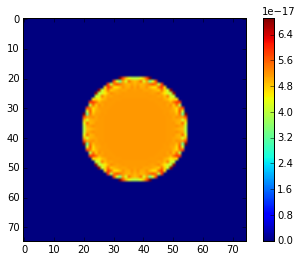

In [14]:
s = stimulus_size(dist, 8, sig_RF)
plt.figure()
plt.imshow(s)
plt.colorbar()

2.64438739683e-09 0.0
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


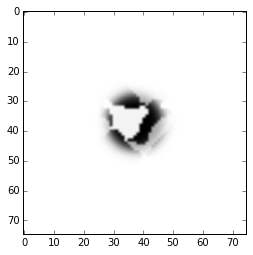

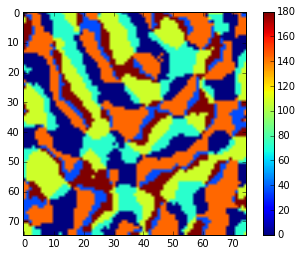

In [15]:
print np.max(h), np.min(h)
plt.figure()
stimulus_img = plt.imshow(h)
stimulus_img.set_cmap('binary')

plt.figure()
plt.imshow(OP_map)
plt.colorbar()

print h

In [26]:
# Run the simulation over time using Euler's method
dt = 0.001 # milliseconds
timesteps = 100

r_E = np.zeros((timesteps, N_pairs, N_pairs))
r_I = np.copy(r_E)

# Initial conditions:
r_E[0,:,:] = 100*np.random.rand(N_pairs, N_pairs)
r_I[0,:,:] = 100*np.random.rand(N_pairs, N_pairs)

I_E = np.zeros((timesteps, N_pairs, N_pairs))
I_I = np.copy(I_E)
# rSS_E = np.copy(I_E)
# rSS_I = np.copy(I_I)

for t in range(1,timesteps):
    # Input drive from external input and network
    
#     print W_EE.shape
#     print r_E[:,:,t-1].shape
#     print np.multiply(W_EE, r_E[t-1,:,:]).shape
    
    I_E[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_EE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T + np.sum( np.reshape(np.multiply(W_EI, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T
    I_I[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_IE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T + np.sum( np.reshape(np.multiply(W_II, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T
    
    # steady state firing rates
    rSS_E = np.multiply(k, np.power(np.maximum(0,I_E[t,:,:]), n_E))
    rSS_I = np.multiply(k, np.power(np.maximum(0,I_I[t,:,:]), n_I))
    
    # set negative steady state rates to zero
#     rSS_E[t,:,:][rSS_E[t,:,:] < 0] = 0
#     rSS_I[t,:,:][rSS_I[t,:,:] < 0] = 0
    
    # instantaneous firing rates approaching steady state
    r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))
    r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))

/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: overflow encountered in power
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: RuntimeWarning: overflow encountered in power
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: overflow encountered in divide
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: RuntimeWarning: invalid value encountered in multiply


In [79]:
print np.max(k), np.min(k), np.max(n_I), np.min(n_I)

print 'Exponent: ', np.power(np.maximum(0,I_E[1,:,:]), n_E)
print 'Product: ', np.multiply(k, np.power(np.maximum(0,I_E[1,:,:]), n_E))

0.0140126622235 0.00959428721658 2.64583581413 1.75493056821
Exponent:  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Product:  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


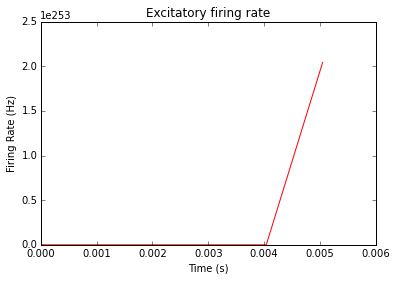

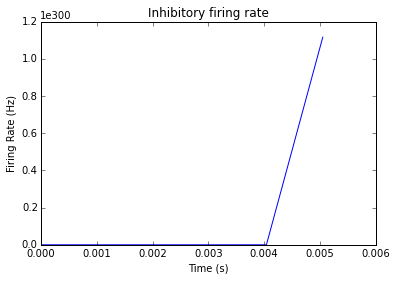

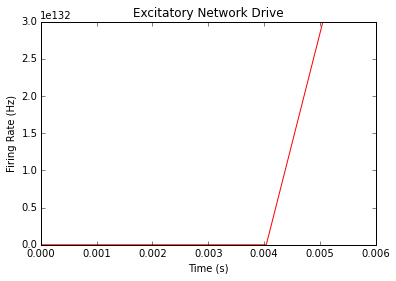

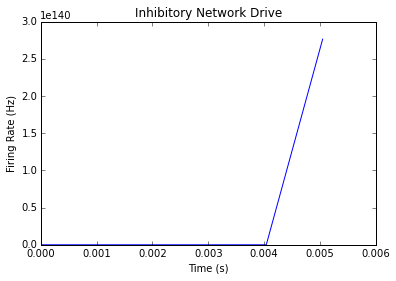

In [22]:
# Plotting results
x = 10
y = 10
plt.figure()
t_range = np.linspace(0,timesteps*dt, timesteps)
plt.plot( t_range, r_E[:,x,y], 'r' )
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Excitatory firing rate')

plt.figure()
plt.plot(t_range, r_I[:,x,y] )
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Inhibitory firing rate')

plt.figure()
plt.plot(t_range, I_E[:,x,y], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Excitatory Network Drive')

plt.figure()
plt.plot(t_range, I_I[:,x,y])
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Inhibitory Network Drive')

In [81]:
print r_E[:,1,1]
print np.min(r_E[:,1,1])

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.36843329e-77
   3.40115785e-76   2.69483040e-75   1.24893234e-74   4.20592780e-74
   1.14394518e-73   2.66868441e-73   5.54521917e-73   1.05256755e-72
   1.85790657e-72   3.08956966e-72   4.88809294e-72   7.41391649e-72
   1.08449453e-71   1.53734435e-71   2.12024447e-71   2.85418626e-71
   3.76044701e-71   4.86019029e-71   6.17408140e-71   7.72192884e-71
   9.52235971e-71   1.15925349e-70   1.39479078e-70   1.66020283e-70
   1.95663923e-70   2.28503358e-70   2.64609706e-70   3.04031601e-70
   3.46795299e-70   3.92905113e-70   4.42344114e-70   4.95075077e-70
   5.51041616e-70   6.10169478e-70   6.72367956e-70   7.37531386e-70
   8.05540697e-70   8.76264989e-70   9.49563108e-70   1.02528521e-69
   1.10327427e-69   1.18336755e-69   1.26539803e-69   1.34919567e-69
   1.43458871e-69   1.52140482e-69   1.60947211e-69   1.69862019e-69
   1.78868095e-69   1.87948943e-69   1.97088449e-69   2.06270938e-69
   2.15481234e-69   2.24704698e-69